![Colegio Bourbaki](./Images/Bourbaki.png)

## Introducción a Modelos Multimodales

**Contexto del reto**

El Institut Louis Bachelier (ILB) es una red de investigación patrocinada en Economía y Finanzas. Es una asociación según la definición de la ley de 1901 y se creó en 2008 a instancias del Tesoro y la Caisse des Dépôts et Consignations. A través de sus actividades, pretende implicar a académicos, autoridades públicas y empresas en proyectos de investigación, así como en eventos científicos y otros foros de intercambio. Las decenas de proyectos de investigación que acoge el ILBf se centran en cuatro transiciones sociales: medioambiental, digital, demográfica y financiera.

El ILB Datalab es un equipo de científicos de datos que trabajan junto a investigadores de la red ILB en proyectos de investigación aplicada para agentes públicos y privados de nuestro ecosistema económico y financiero. El ILB datalab ha recopilado recientemente una gran cantidad de datos inmobiliarios franceses y le gustaría realizar análisis y experimentos con ellos. Este reto es una oportunidad para hacerlo.

**Objetivos del reto**

El proyecto es una tarea de regresión que trata sobre la estimación del precio de los inmuebles. La estimación del precio de los inmuebles de viviendas es un tema bastante común, con una importante bibliografía sobre la estimación de precios basada en datos habituales como: ubicación, superficie, terreno, número de dormitorios, antigüedad del edificio... Las aproximaciones suelen ser suficientes para estimar el rango de precios, pero carecen de precisión. Sin embargo, pocos han trabajado para ver si la adición de fotos del bien aportaría información complementaria, permitiendo una estimación más precisa del precio.

Así pues, el objetivo es trabajar en la modelización de los precios inmobiliarios de la vivienda francesa a partir de los datos tabulares jerárquicos habituales y, unas pocas fotos (entre 1 y 6) para cada bien y ver si permite un mejor rendimiento que un modelo entrenado sin las fotos.

Valoraremos la interpretabilidad de los resultados para comprender mejor las características valiosas.

**Descripción de los datos**

La salida y representa los precios inmobiliarios de vivienda ofrecidos de los activos franceses en euros.

La entrada X contiene

* un identificador del anuncio
* el tipo de propiedad (casa, apartamento, condominio, mansión...)
* la ubicación (latitud aproximada, longitud aproximada, ciudad, código postal, exposición, piso cuando proceda...)
* el tamaño (superficie habitable y superficie del terreno cuando proceda),
* el número de habitaciones, dormitorios, baños...
* indicadores de eficiencia energética (energía y emisiones de gases de efecto invernadero)
* el número de fotos adjuntas al anuncio
* indicadores de si hay sótano, balcón, aire acondicionado...


Junto con estos datos tabulares, proporcionamos una carpeta comprimida que contiene de 1 a 6 fotos por anuncio (véanse los archivos suplementarios). Para cada anuncio del conjunto de datos tabulares, las fotos correspondientes se encuentran en la carpeta denominada "ann_XX", donde XX corresponde al identificador del anuncio.


### Librerías

In [75]:
#Data Analysis
import pandas as pd
import numpy as np
import missingno as msno

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Pytorch
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

#Utils
import os
import sys
from PIL import Image
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

### Configuraciones

In [2]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [4]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
device

'cuda:0'

In [5]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION",
)
! nvidia-smi
print("__CUDNN VERSION:", torch.backends.cudnn.version())
! nvcc --version
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())

__Python VERSION: 3.11.8 (main, Feb  9 2024, 16:48:53) [GCC 11.4.0]
__pyTorch VERSION: 2.2.0+cu121
__CUDA VERSION
Sun Apr 28 10:23:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   70C    P5              8W /   50W |      95MiB /   4096MiB |     36%      Default |
|                         

### Funciones de ayuda

In [6]:
def correlation(dataframe, plot=True, matrix=False):
    """Devuelve la matriz de correlación de un dataframe,
    si plot=True, muestra un mapa de calor de la matriz de correlación,
    si matrix=True, devuelve la matriz de correlación"""
    corr = dataframe.corr(method="spearman")

    if plot:
        fig, ax = plt.subplots(figsize=(25, 20))
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
        cmap = sns.color_palette("coolwarm", as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f", square=True)

    if matrix:
        return corr

### Carga de datos

In [7]:
df_features = pd.read_csv('./Data/X_train_J01Z4CN.csv')

In [8]:
df_features

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,35881571,appartement,43.480292,-1.484324,bayonne,64100,2995.0,NaN,NaN,255.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37364,35890109,appartement,48.861391,2.401158,paris-20eme,75020,36.0,4.0,NaN,229.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37365,36010245,appartement,44.397837,-1.164312,biscarrosse,40600,99.0,2.0,NaN,NaN,...,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37366,35864579,duplex,48.864204,2.808693,magny-le-hongre,77700,9281.0,NaN,NaN,NaN,...,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Veamos que signfican las columnas:

| Name                          | Type    | Description                                                                                                           | Compulsory Field on Web Platform |
|-------------------------------|---------|-----------------------------------------------------------------------------------------------------------------------|----------------------------------|
| `id_annonce`                  | `str`   | Unique listing identification code                                                                                    | True                             |
| `price`                       | `float` | Price at which the property is listed                                                                                 | True                             |
| `property_type`               | `str`   | Property type (house, apartment, etc.)                                                                                | True                             |
| `approximate_latitude`        | `float` | Latitude of the property with a small random Gaussian added for the sake of anonymization                             | False                            |
| `approximate_longitude`       | `float` | Longitude of the property with a small random Gaussian added for the sake of anonymization                            | False                            |
| `city`                        | `str`   | City in which the property is located                                                                                 | True                             |
| `postal_code`                 | `int`   | Postal code of the property                                                                                           | True                             |
| `size`                        | `float` | Living area of the property                                                                                           | False                            |
| `floor`                       | `float` | Floor at which the property is located                                                                                | False                            |
| `land_size`                   | `float` | Size of the land that comes with the property                                                                         | False                            |
| `energy_performance_value`    | `float` | Energy performance value in kWh/m²/year                                                                               | False                            |
| `energy_performance_category` | `char`  | Energy performance category as defined by the French DPE regulation: [DPE](https://www.ecologie.gouv.fr/diagnostic-performance-energetique-dpe) | False                            |
| `ghg_value`                   | `float` | Greenhouse gas emission performance value in kg eqCO2/m²                                                              | False                            |
| `ghg_category`                | `char`  | Greenhouse gas emission performance category as defined by the French DPE regulation: [DPE](https://www.ecologie.gouv.fr/diagnostic-performance-energetique-dpe) | False                            |
| `exposition`                  | `str`   | Direction the property is facing                                                                                      | False                            |
| `nb_rooms`                    | `int`   | Number of rooms in the property                                                                                       | False                            |
| `nb_bedrooms`                 | `int`   | Number of bedrooms in the property                                                                                    | False                            |
| `nb_bathrooms`                | `int`   | Number of bathrooms in the property                                                                                   | False                            |
| `nb_parking_places`           | `int`   | Number of parking places coming with the property                                                                     | False                            |
| `nb_boxes`                    | `int`   | Number of boxes coming with the property                                                                              | False                            |
| `nb_photos`                   | `int`   | Number of photos posted on the listing                                                                                | False                            |
| `has_a_balcony`               | `binary`| Indicator whether there is a balcony in the property (1 if true, 0 if false)                                          | False                            |
| `nb_terraces`                 | `binary`| Number of terraces in the property                                                                                    | False                            |
| `has_a_cellar`                | `binary`| Indicator whether there is a cellar in the property (1 if true, 0 if false)                                           | False                            |
| `has_a_garage`                | `binary`| Indicator whether there is a garage in the property (1 if true, 0 if false)                                           | False                            |
| `has_air_conditioning`        | `binary`| Indicator whether there is air conditioning in the property (1 if true, 0 if false)                                    | False                            |
| `last_floor`                  | `binary`| Indicator whether the property is located on the top floor (1 if true, 0 if false)                                     | False                            |
| `upper_floors`                | `binary`| Indicator whether the property is located in the upper floors (1 if true, 0 if false)                                  | False                            |


In [9]:
df_prices = pd.read_csv('./Data/y_train_OXxrJt1.csv')

In [10]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_annonce  37368 non-null  int64  
 1   price       37368 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 584.0 KB


In [11]:
df = pd.merge(df_features, df_prices, on='id_annonce', how='inner')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_annonce                   37368 non-null  int64  
 1   property_type                37368 non-null  object 
 2   approximate_latitude         37368 non-null  float64
 3   approximate_longitude        37368 non-null  float64
 4   city                         37368 non-null  object 
 5   postal_code                  37368 non-null  int64  
 6   size                         36856 non-null  float64
 7   floor                        9743 non-null   float64
 8   land_size                    15581 non-null  float64
 9   energy_performance_value     19068 non-null  float64
 10  energy_performance_category  19068 non-null  object 
 11  ghg_value                    18530 non-null  float64
 12  ghg_category                 18530 non-null  object 
 13  exposition      

In [13]:
df=df.convert_dtypes()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_annonce                   37368 non-null  Int64  
 1   property_type                37368 non-null  string 
 2   approximate_latitude         37368 non-null  Float64
 3   approximate_longitude        37368 non-null  Float64
 4   city                         37368 non-null  string 
 5   postal_code                  37368 non-null  Int64  
 6   size                         36856 non-null  Int64  
 7   floor                        9743 non-null   Int64  
 8   land_size                    15581 non-null  Int64  
 9   energy_performance_value     19068 non-null  Int64  
 10  energy_performance_category  19068 non-null  string 
 11  ghg_value                    18530 non-null  Int64  
 12  ghg_category                 18530 non-null  string 
 13  exposition      

### Análisis Exploratorio

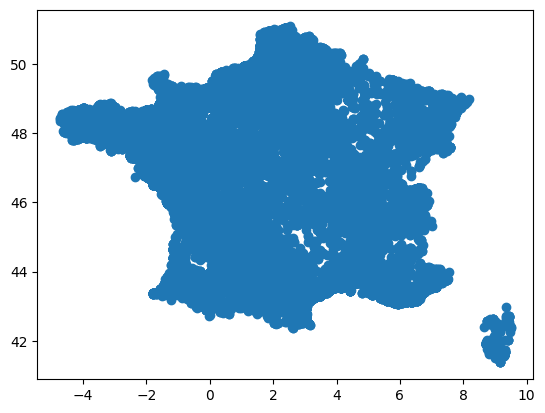

In [15]:
plt.scatter(df['approximate_longitude'], df['approximate_latitude'])
plt.show()

Veamos los valores nulos:

In [16]:
print("Numero de valores NaN por columna:")
df.isna().sum()

Numero de valores NaN por columna:


id_annonce                         0
property_type                      0
approximate_latitude               0
approximate_longitude              0
city                               0
postal_code                        0
size                             512
floor                          27625
land_size                      21787
energy_performance_value       18300
energy_performance_category    18300
ghg_value                      18838
ghg_category                   18838
exposition                     28274
nb_rooms                        1566
nb_bedrooms                     2733
nb_bathrooms                   13273
nb_parking_places                  0
nb_boxes                           0
nb_photos                          0
has_a_balcony                      0
nb_terraces                        0
has_a_cellar                       0
has_a_garage                       0
has_air_conditioning               0
last_floor                         0
upper_floors                       0
p

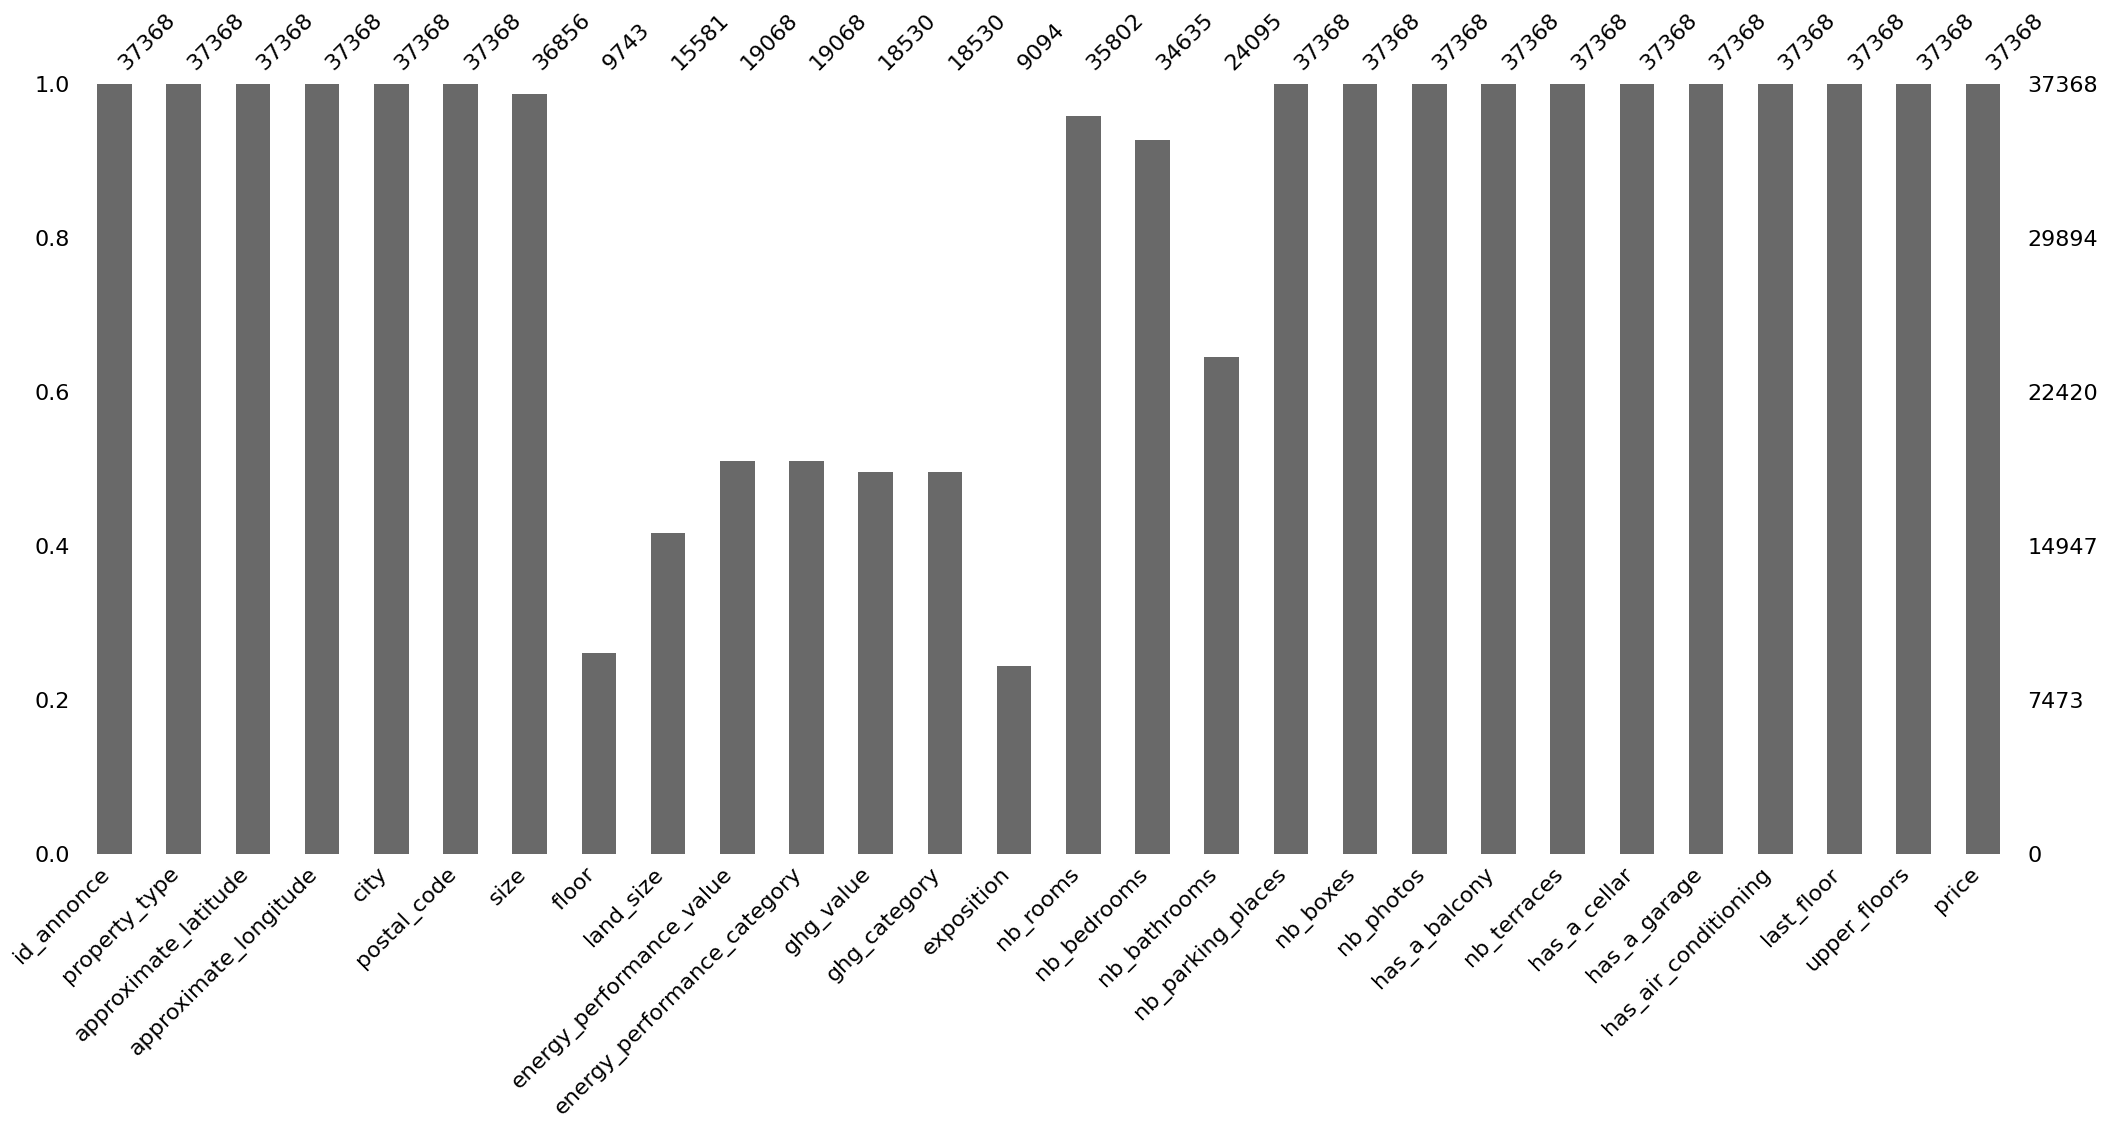

In [17]:
msno.bar(df)
plt.show()

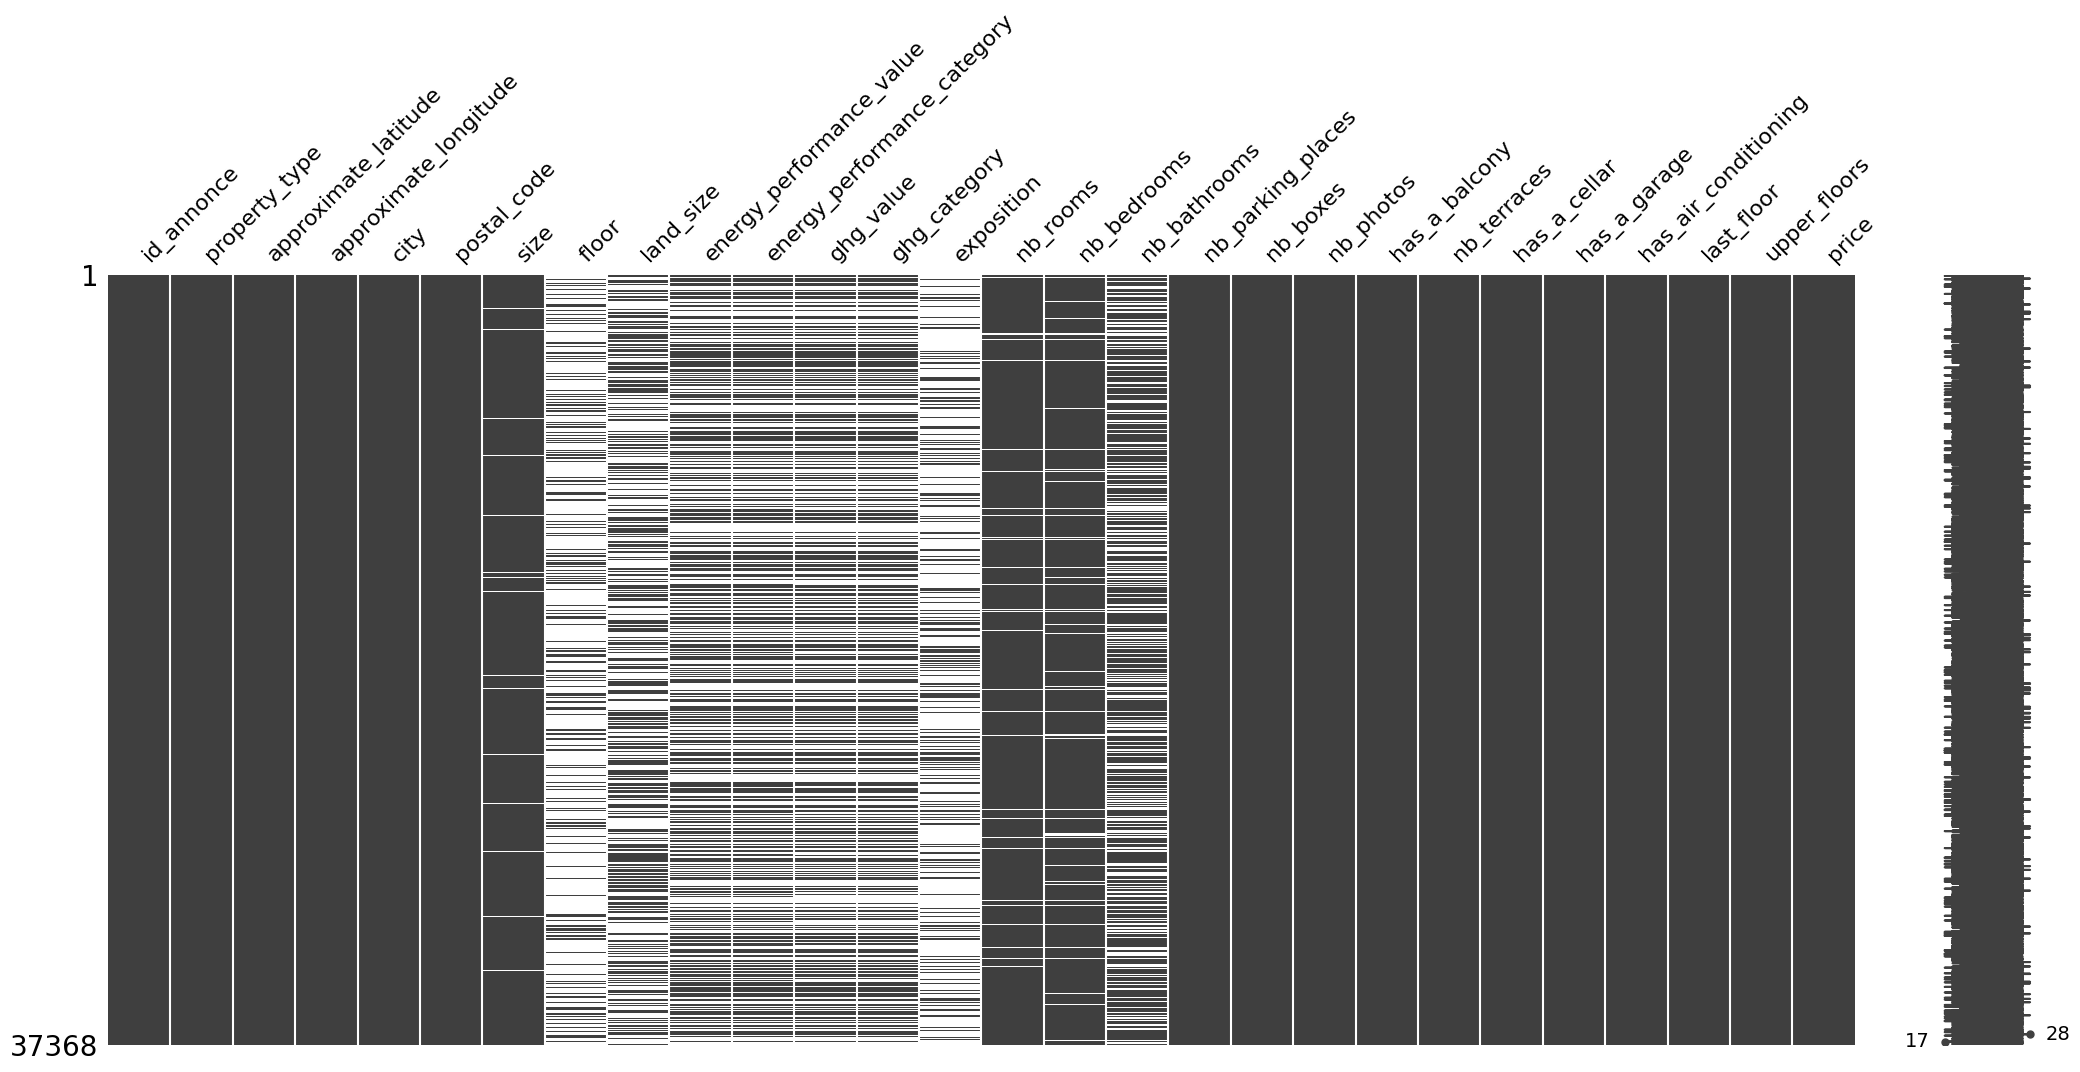

In [18]:
msno.matrix(df)
plt.show()

In [19]:
print(
    f"El número total de valores NaN en el archivo y_train es {df.isna().sum().sum()}"
)

El número total de valores NaN en el archivo y_train es 170046


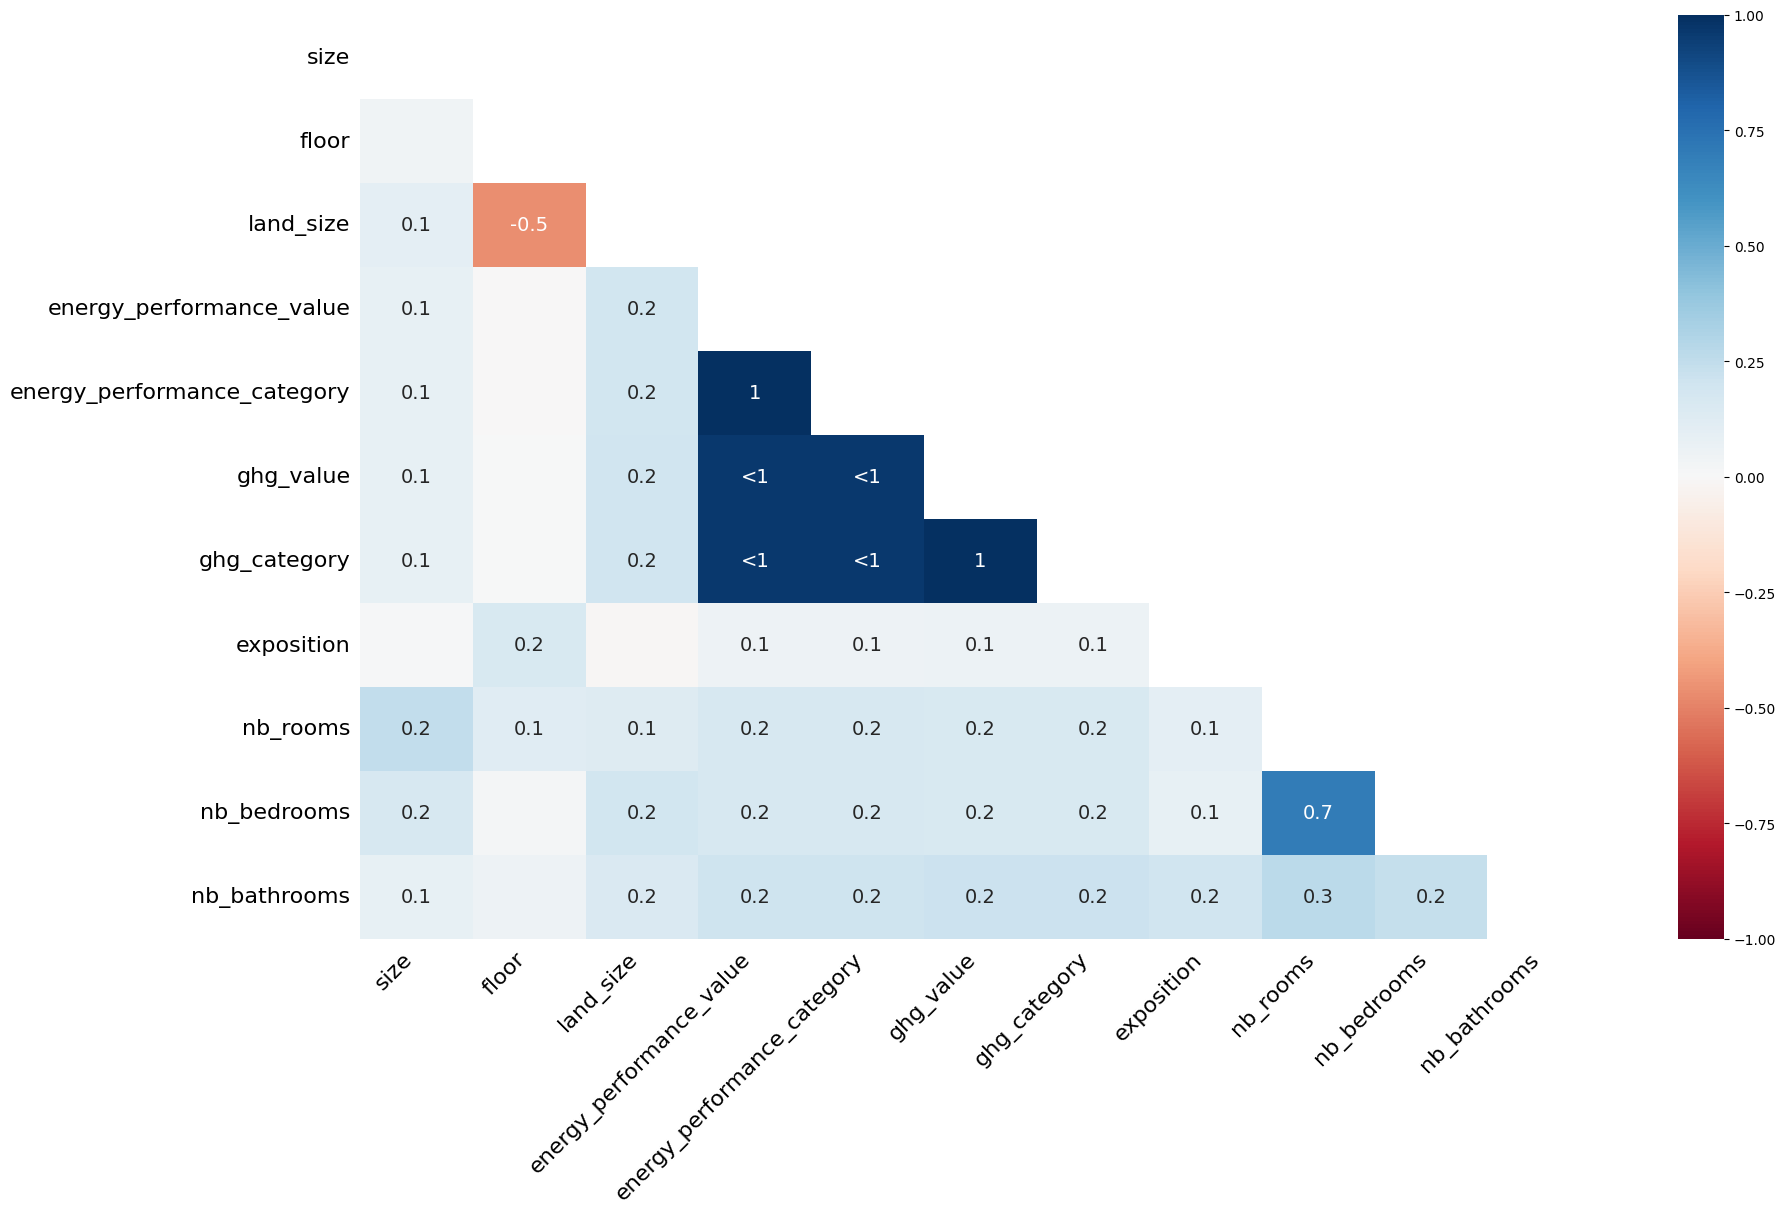

In [20]:
msno.heatmap(df)
plt.show()

Podemos desprendernos de varias columnas:

* 'city' y 'postal_code' están ya codificadas por la longitud y la latitud.
* 'energy_performance_category' está codificada como una variable ordinal 'energy_performance_value' como así también 'ghg_category'.
* 'exposition' tiene muchos valores nulos por lo tanto podríamos tachar esa columna, aunque quedaría como pendiente ver si tiene impacto en el valor de la casa.

In [21]:
columns_to_drop = ['city', 'postal_code', 'energy_performance_category', 'ghg_category', 'exposition']

In [22]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_annonce                37368 non-null  Int64  
 1   property_type             37368 non-null  string 
 2   approximate_latitude      37368 non-null  Float64
 3   approximate_longitude     37368 non-null  Float64
 4   size                      36856 non-null  Int64  
 5   floor                     9743 non-null   Int64  
 6   land_size                 15581 non-null  Int64  
 7   energy_performance_value  19068 non-null  Int64  
 8   ghg_value                 18530 non-null  Int64  
 9   nb_rooms                  35802 non-null  Int64  
 10  nb_bedrooms               34635 non-null  Int64  
 11  nb_bathrooms              24095 non-null  Int64  
 12  nb_parking_places         37368 non-null  Int64  
 13  nb_boxes                  37368 non-null  Int64  
 14  nb_pho

In [24]:
df = pd.get_dummies(df)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_annonce                       37368 non-null  Int64  
 1   approximate_latitude             37368 non-null  Float64
 2   approximate_longitude            37368 non-null  Float64
 3   size                             36856 non-null  Int64  
 4   floor                            9743 non-null   Int64  
 5   land_size                        15581 non-null  Int64  
 6   energy_performance_value         19068 non-null  Int64  
 7   ghg_value                        18530 non-null  Int64  
 8   nb_rooms                         35802 non-null  Int64  
 9   nb_bedrooms                      34635 non-null  Int64  
 10  nb_bathrooms                     24095 non-null  Int64  
 11  nb_parking_places                37368 non-null  Int64  
 12  nb_boxes          

In [26]:
df.set_index('id_annonce', inplace=True)

In [27]:
index_series = pd.Series(df.index)

In [28]:
df

,approximate_latitude,approximate_longitude,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
id_annonce,,,,,,,,,,,,,,,,,,,,,
35996577,43.64388,7.117183,63,<NA>,<NA>,<NA>,<NA>,3,2,<NA>,...,False,False,False,False,False,False,False,False,False,False
35811033,45.695757,4.89561,90,3,<NA>,223,52,5,4,<NA>,...,False,False,False,False,False,False,False,False,False,False
35731841,47.966791,-1.220451,61,<NA>,370,<NA>,<NA>,2,1,<NA>,...,True,False,False,False,False,False,False,False,False,False
35886765,47.289292,-1.878805,142,<NA>,764,217,44,4,3,<NA>,...,True,False,False,False,False,False,False,False,False,False
35781137,45.718992,4.844234,88,3,<NA>,<NA>,<NA>,4,3,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35881571,43.480292,-1.484324,2995,<NA>,<NA>,255,59,1,<NA>,1,...,False,False,False,False,False,False,False,False,False,False
35890109,48.861391,2.401158,36,4,<NA>,229,53,2,1,<NA>,...,False,False,False,False,False,False,False,False,False,False
36010245,44.397837,-1.164312,99,2,<NA>,<NA>,<NA>,4,3,<NA>,...,False,False,False,False,False,False,False,False,False,False


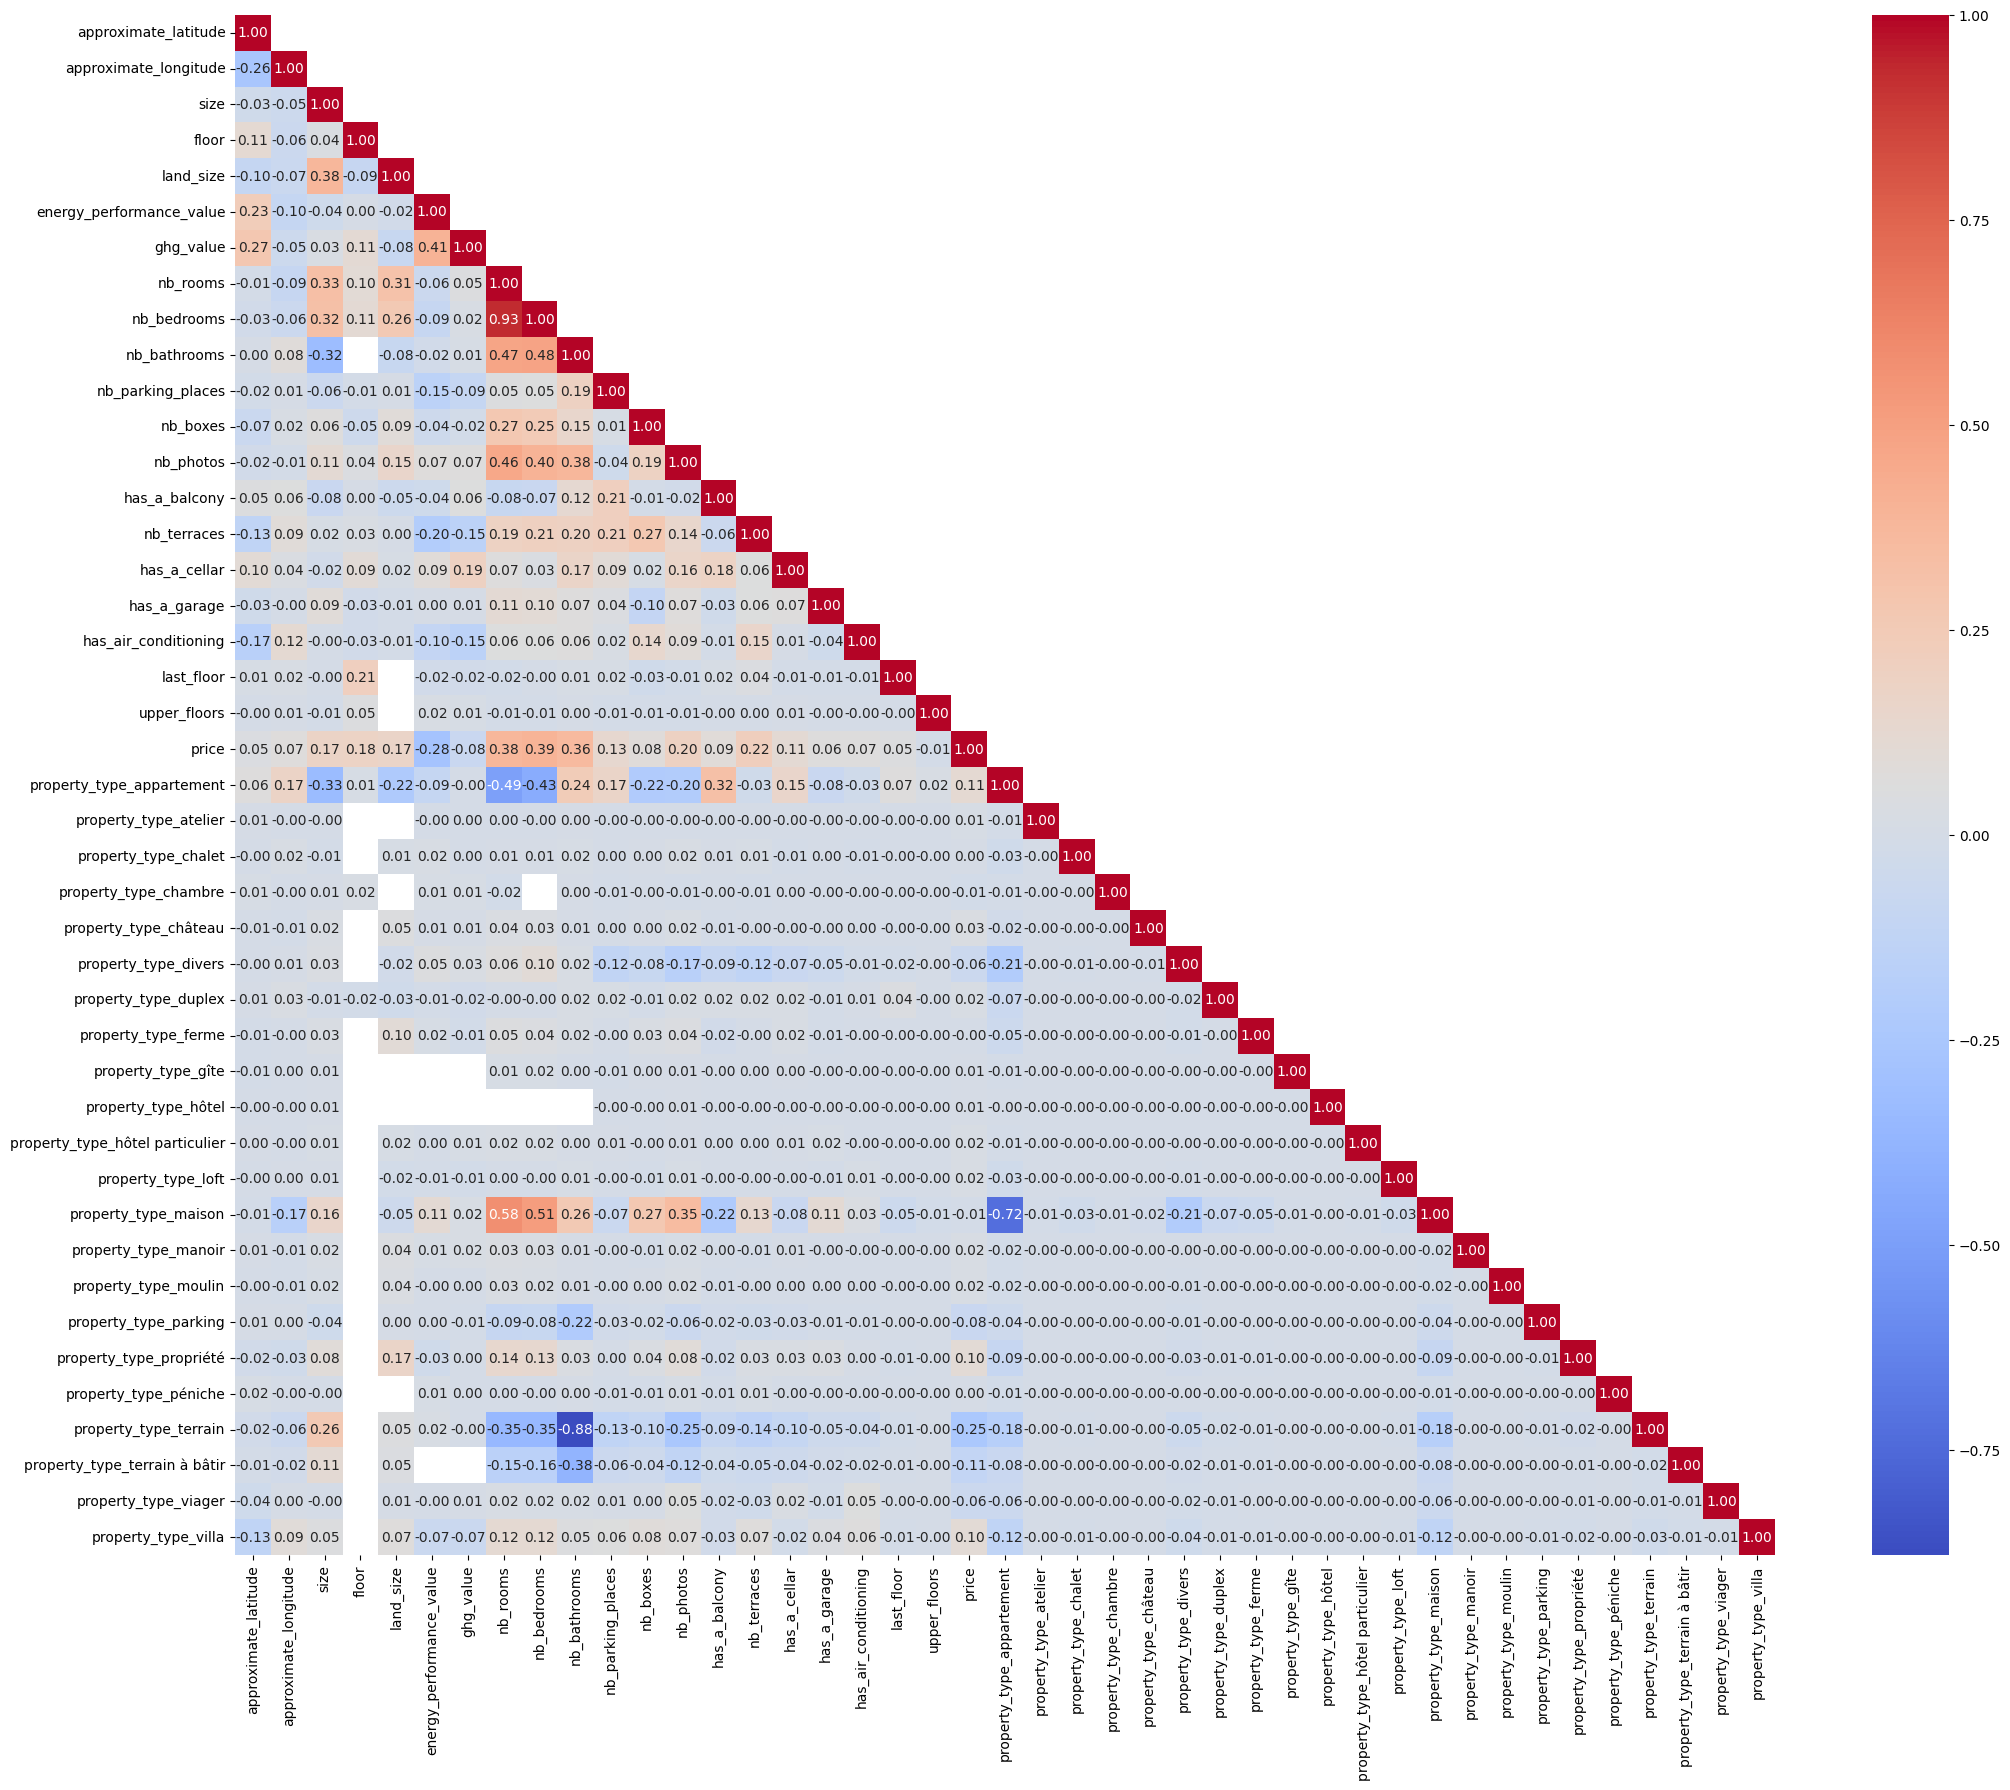

In [29]:
correlation(df)

Vamos a utilizar la clase *IterativeImputer* de scikit-learn: es un enfoque sofisticado, que modela cada característica con valores nulos como una función de otras características, y utiliza esa estimación para la imputación. Lo hace de forma iterativa: en cada paso, una columna de característica se designa como salida y y las otras columnas de característica se tratan como entradas X. Se ajusta un regresor en (X, y) para y conocido. A continuación, el regresor se utiliza para predecir los valores que faltan de y. Esto se hace para cada característica de forma iterativa y, a continuación, se repite para rondas de imputación max_iter. Se devuelven los resultados de la última ronda de imputación.

Este estimador es todavía experimental por ahora: los parámetros por defecto o los detalles de comportamiento podrían cambiar sin ningún ciclo de depreciación. Para utilizarlo, es necesario importar explícitamente enable_iterative_imputer. 


In [30]:
imputer = IterativeImputer(random_state=42, initial_strategy='median', verbose=1, imputation_order='random')

In [31]:
imputer.fit(df)

[IterativeImputer] Completing matrix with shape (37368, 43)
[IterativeImputer] Change: 334249.459097317, scaled tolerance: 6203.7 
[IterativeImputer] Change: 9617.511086205166, scaled tolerance: 6203.7 
[IterativeImputer] Change: 11910.930665252334, scaled tolerance: 6203.7 
[IterativeImputer] Change: 5666.441354604711, scaled tolerance: 6203.7 
[IterativeImputer] Early stopping criterion reached.


IterativeImputer(imputation_order='random', initial_strategy='median',
                 random_state=42, verbose=1)

In [32]:
df = pd.DataFrame(imputer.transform(df), columns=df.columns)

[IterativeImputer] Completing matrix with shape (37368, 43)


In [33]:
df = pd.merge(index_series, df, left_index=True, right_index=True)

In [34]:
df

,id_annonce,approximate_latitude,approximate_longitude,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
0,35996577,43.643880,7.117183,63.0,2.582317,3301.365672,183.517921,20.858543,3.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35811033,45.695757,4.895610,90.0,3.000000,1763.154931,223.000000,52.000000,5.0,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,47.966791,-1.220451,61.0,3.222104,370.000000,287.049217,34.426839,2.0,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,47.289292,-1.878805,142.0,3.407158,764.000000,217.000000,44.000000,4.0,3.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35781137,45.718992,4.844234,88.0,3.000000,4452.904747,82.855640,31.484300,4.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,35881571,43.480292,-1.484324,2995.0,2.763984,4084.855579,255.000000,59.000000,1.0,0.709122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37364,35890109,48.861391,2.401158,36.0,4.000000,3711.516978,229.000000,53.000000,2.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37365,36010245,44.397837,-1.164312,99.0,2.000000,3106.572480,281.275920,35.006407,4.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37366,35864579,48.864204,2.808693,9281.0,2.392657,11656.910072,167.433841,19.379296,5.0,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Podemos chequear el poblado de valores nulos:

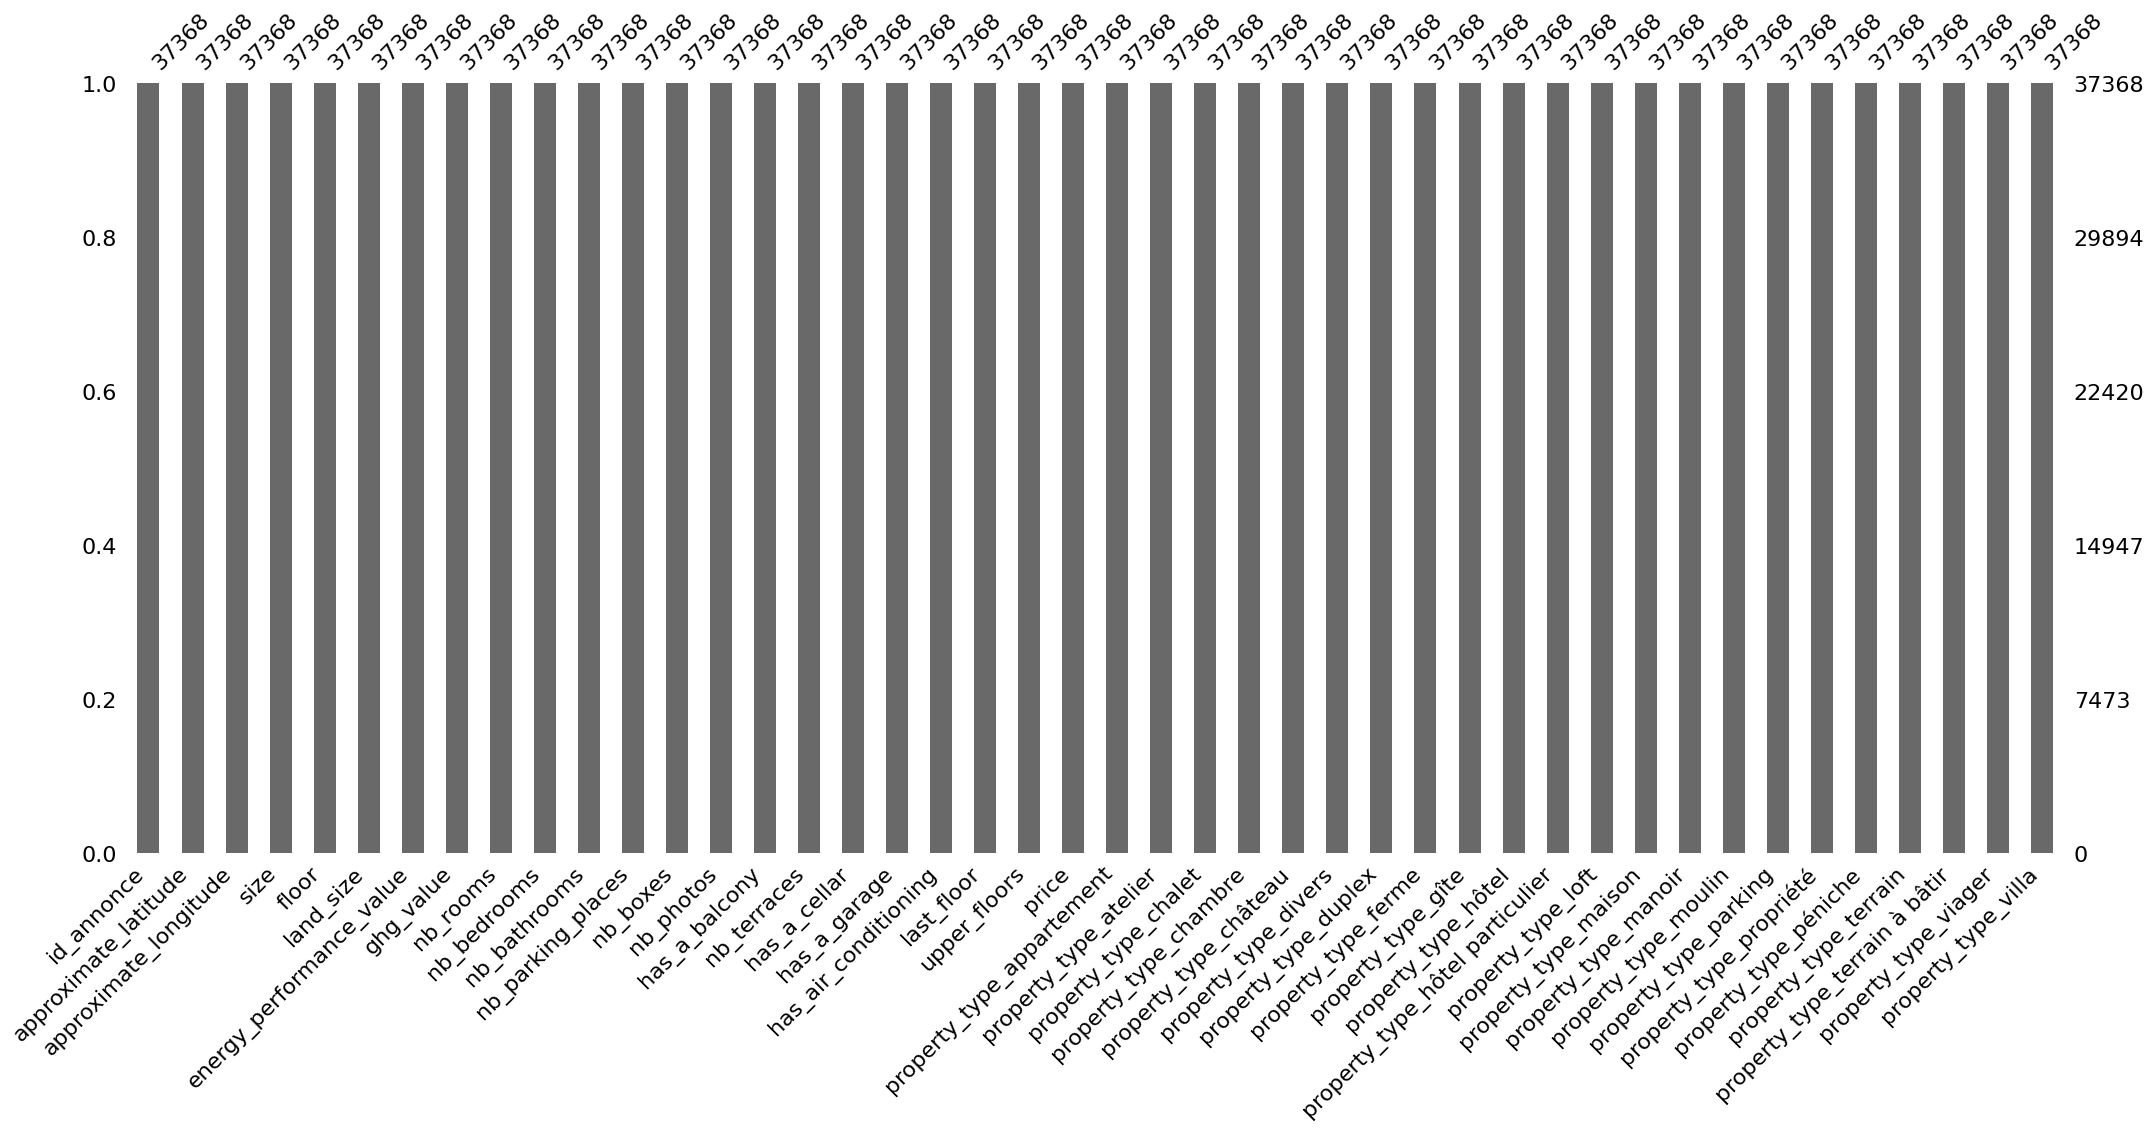

In [35]:
msno.bar(df)
plt.show()

In [36]:
df = df.convert_dtypes()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_annonce                       37368 non-null  Int64  
 1   approximate_latitude             37368 non-null  Float64
 2   approximate_longitude            37368 non-null  Float64
 3   size                             37368 non-null  Float64
 4   floor                            37368 non-null  Float64
 5   land_size                        37368 non-null  Float64
 6   energy_performance_value         37368 non-null  Float64
 7   ghg_value                        37368 non-null  Float64
 8   nb_rooms                         37368 non-null  Float64
 9   nb_bedrooms                      37368 non-null  Float64
 10  nb_bathrooms                     37368 non-null  Float64
 11  nb_parking_places                37368 non-null  Int64  
 12  nb_boxes          

Veamos las imágenes:

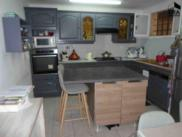

In [38]:
image_path = "./Data/reduced_images/train/ann_6774630/67ec78f2ef878dd921eb55125b56a5c4a8d417dd.jpg"
image = Image.open(image_path)
image

In [39]:
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 182, Height: 137


In [40]:
if image.mode == "L":
    channels = 1
elif image.mode == "RGB":
    channels = 3
elif image.mode == "RGBA":
    channels = 4
else:
    channels = (
        None  # For modes that don't directly map to a specific number of channels
    )

# Print the number of channels
if channels:
    print(f"Channels: {channels}")
else:
    print(
        f"Image mode '{image.mode}' is not directly mapped to a specific number of channels."
    )

Channels: 3


Vamos a determinar el tamaño de resizing de las imágenes para el modelo:

In [41]:
resize = (128, 128)

Veamos cuál es el máximo y mínimo número de fotos por registro:

In [42]:
print(df['nb_photos'].max())
print(df['nb_photos'].min())

50
1


Un total de fotos de:

In [43]:
print(df['nb_photos'].sum())

298165


Veamos el histograma:

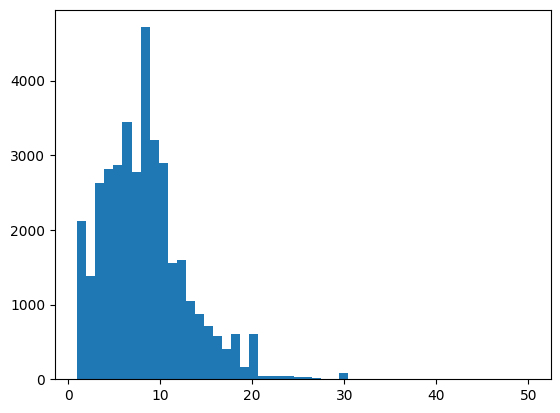

In [44]:
plt.hist(df['nb_photos'], bins=50)
plt.show()

In [45]:
df['nb_photos'].describe()

count     37368.0
mean     7.979153
std      4.646145
min           1.0
25%           5.0
50%           8.0
75%          10.0
max          50.0
Name: nb_photos, dtype: Float64

Primero vamos a realizar un escalado y luego, un split del dataframe:

In [46]:
df = df.sample(frac=1).reset_index(drop=True)

In [47]:
latitude = df['approximate_latitude']
longitude = df['approximate_longitude']

In [48]:
df.drop(['id_annonce','approximate_latitude', 'approximate_longitude'], axis=1, inplace=True)

In [49]:
minmax_scaler = MinMaxScaler()
df = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)

In [50]:
df

,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
0,0.004650,0.428499,0.001187,0.025522,0.089779,0.030769,0.035507,0.333333,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016572,0.427406,0.001614,0.025137,0.090267,0.023077,0.018733,0.332679,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.004641,0.429752,0.000544,0.025121,0.088892,0.023077,0.027120,0.328420,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.004561,0.425060,0.001079,0.025629,0.088945,0.023077,0.027120,0.333333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015964,0.427406,0.000896,0.024406,0.091355,0.023077,0.027120,0.333333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,0.004663,0.427071,0.002141,0.025112,0.090498,0.030769,0.035507,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37364,0.004653,0.426301,0.000271,0.025693,0.089938,0.030769,0.027120,0.332602,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37365,0.004592,0.427225,0.000588,0.025453,0.089607,0.030769,0.035507,0.333333,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37366,0.004725,0.427293,0.000643,0.025552,0.090031,0.030769,0.035507,0.333333,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df = pd.merge(index_series, df, left_index=True, right_index=True)
df = pd.merge(df, longitude, left_index=True, right_index=True)
df = pd.merge(df, latitude, left_index=True, right_index=True)

In [52]:
df

,id_annonce,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,...,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa,approximate_longitude,approximate_latitude
0,35996577,0.004650,0.428499,0.001187,0.025522,0.089779,0.030769,0.035507,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.424635,43.533456
1,35811033,0.016572,0.427406,0.001614,0.025137,0.090267,0.023077,0.018733,0.332679,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.343769,48.894582
2,35731841,0.004641,0.429752,0.000544,0.025121,0.088892,0.023077,0.027120,0.328420,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.901236,42.70399
3,35886765,0.004561,0.425060,0.001079,0.025629,0.088945,0.023077,0.027120,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.253723,48.897775
4,35781137,0.015964,0.427406,0.000896,0.024406,0.091355,0.023077,0.027120,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.033425,42.787971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,35881571,0.004663,0.427071,0.002141,0.025112,0.090498,0.030769,0.035507,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.253023,43.702502
37364,35890109,0.004653,0.426301,0.000271,0.025693,0.089938,0.030769,0.027120,0.332602,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.518505,44.265965
37365,36010245,0.004592,0.427225,0.000588,0.025453,0.089607,0.030769,0.035507,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.433648,43.716703
37366,35864579,0.004725,0.427293,0.000643,0.025552,0.090031,0.030769,0.035507,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.81643,45.177145


In [53]:
train_size = int(0.8 * len(df))
validation_size = int(0.05 * train_size)
test_size = len(df) - train_size - validation_size  # No data is left out due to rounding

# Split the DataFrame
train_df = df[:train_size]
validation_df = df[train_size:train_size + validation_size]
test_df = df[train_size + validation_size:]

In [54]:
print(f"Total records: {len(df)}")
print(f"Training records: {len(train_df)}")
print(f"Validation records: {len(validation_df)}")
print(f"Test records: {len(test_df)}")

Total records: 37368
Training records: 29894
Validation records: 1494
Test records: 5980


### Modelo Multimodal

In [55]:
class HouseDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None, max_images=50):
        """
        dataframe: A DataFrame containing the listing IDs, paths to images, and tabular features.
        image_folder: Path to the directory containing images.
        transform: PyTorch transforms for processing the images.
        """
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Resize((resize[0], resize[1])),
            transforms.ToTensor(),
        ])
        self.max_images = max_images

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        listing_id = int(row['id_annonce'])
        image_path = os.path.join(self.image_folder, f"ann_{listing_id}")

        # Process all images for a given listing
        images = []
        for file in os.listdir(image_path):
            if file.endswith('.jpg') and len(images) < self.max_images:
                img = Image.open(os.path.join(image_path, file))
                images.append(self.transform(img))
            elif len(images) >= self.max_images:
                break

        # Ensure there are max_images by padding with zeros if necessary
        while len(images) < self.max_images:
            images.append(torch.zeros(3, resize[0], resize[1]))  # Adjust zeros tensor to match image dimensions

        # Stack images into a single tensor and get the mean
        images = torch.stack(images).mean(dim=0)
    
        # Extract tabular data
        tabular_data = torch.tensor(row.drop(['id_annonce', 'price']).values)

        # Price
        price = torch.tensor(row['price'])

        return images.float().to(device), tabular_data.float().to(device), price.float().to(device)

In [56]:
class HousePricePredictor(nn.Module):
    def __init__(self, num_tabular_features, num_image_features=512, hidden_dimension=256, output_features=1):
        super(HousePricePredictor, self).__init__()
        
        # Image processing module (use a pretrained ResNet and modify it)
        weights = models.resnet.ResNet18_Weights.DEFAULT  # Ensures using the most up-to-date pretrained weights
        base_model = models.resnet18(weights=weights)
        self.cnn = nn.Sequential(
            *list(base_model.children())[:-1],  # Removing the fully connected layer
            nn.Flatten(),
            #nn.Linear(512, num_image_features)  # Transform to match tabular features size
        )
        
        # Tabular data processing module
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, num_image_features),  # Output size matches CNN feature size
            nn.BatchNorm1d(num_image_features),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Combining features using Hadamard product
        self.combined_fc = nn.Sequential(
            nn.Linear(num_image_features, hidden_dimension),  # Dimensionality reduction if needed
            nn.BatchNorm1d(hidden_dimension),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dimension, output_features)
        )
        
    def forward(self, images, tabular_data):
        # Embeddings
        img_features = self.cnn(images)
        tab_features = self.tabular_fc(tabular_data)
        
        # Hadamard product
        combined_features = img_features * tab_features  # Element-wise multiplication
        
        # Final prediction
        output = self.combined_fc(combined_features)
        return output

In [57]:
BATCH_SIZE = 64

In [58]:
# Data loading
dataset_train = HouseDataset(train_df, './Data/reduced_images/train', transform=None)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataset_val = HouseDataset(validation_df, './Data/reduced_images/train', transform=None)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

In [59]:
# model
model = HousePricePredictor(num_tabular_features=df.shape[1]-2, num_image_features=512, hidden_dimension=256, output_features=1)
model.to(device)

HousePricePredictor(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [60]:
# Tunners
LR = 0.0001
EPOCHS = 15

In [61]:
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=LR*0.1, amsgrad=True)
criterion = nn.MSELoss().to(device)

In [62]:
train_loss = []
val_loss = []

In [63]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, criterion, epochs):
    scaler = GradScaler()  # For mixed precision training
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training")
        
        #Training phase
        for images, tabular_data, prices in train_progress_bar:
            optimizer.zero_grad()
            with autocast():  # Mixed precision
                predictions = model(images, tabular_data)
                loss = criterion(predictions.view_as(prices), prices)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()
            train_progress_bar.set_postfix({'train_loss': loss.item()})

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        val_progress_bar = tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validation")
        with torch.no_grad():
            for images, tabular_data, prices in val_progress_bar:
                with autocast():
                    predictions = model(images, tabular_data)
                    loss = criterion(predictions.view_as(prices), prices)
                total_val_loss += loss.item()
                val_progress_bar.set_postfix({'val_loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(validation_dataloader)
        train_loss.append(avg_train_loss)
        val_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Average Train Loss: {avg_train_loss}, Average Val Loss: {avg_val_loss}\n')


In [64]:
train_model(model, dataloader_train ,dataloader_val, optimizer, criterion, epochs=EPOCHS)

Epoch 1/15 - Validation: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s, val_loss=0.0141]


Epoch 1, Average Train Loss: 0.09388657888142854, Average Val Loss: 0.024174474955846865



Epoch 2/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s, val_loss=0.0127] 


Epoch 2, Average Train Loss: 0.04662134337764329, Average Val Loss: 0.019314499261478584



Epoch 3/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, val_loss=0.0122]


Epoch 3, Average Train Loss: 0.03085551525736785, Average Val Loss: 0.016155720533182222



Epoch 4/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, val_loss=0.0119] 


Epoch 4, Average Train Loss: 0.024277501731601536, Average Val Loss: 0.01604077996065219



Epoch 5/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, val_loss=0.0111] 


Epoch 5, Average Train Loss: 0.02173315618847871, Average Val Loss: 0.015461015689652413



Epoch 6/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s, val_loss=0.0114] 


Epoch 6, Average Train Loss: 0.020094812811853793, Average Val Loss: 0.015459881979040802



Epoch 7/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s, val_loss=0.0108] 


Epoch 7, Average Train Loss: 0.01880900241319154, Average Val Loss: 0.015324788653136542



Epoch 8/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s, val_loss=0.0109] 


Epoch 8, Average Train Loss: 0.018239580332619958, Average Val Loss: 0.014882062814043215



Epoch 9/15 - Validation: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s, val_loss=0.0107] 


Epoch 9, Average Train Loss: 0.017564517673717923, Average Val Loss: 0.015056162005445609



Epoch 10/15 - Validation: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s, val_loss=0.0105] 


Epoch 10, Average Train Loss: 0.017292201566772584, Average Val Loss: 0.01486499332046757



Epoch 11/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s, val_loss=0.0101] 


Epoch 11, Average Train Loss: 0.01700487918455281, Average Val Loss: 0.01466621992100651



Epoch 12/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.67it/s, val_loss=0.0113] 


Epoch 12, Average Train Loss: 0.01643229110671892, Average Val Loss: 0.0151021713973023



Epoch 13/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, val_loss=0.0104] 


Epoch 13, Average Train Loss: 0.01606150259140433, Average Val Loss: 0.01447098539210856



Epoch 14/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s, val_loss=0.0109] 


Epoch 14, Average Train Loss: 0.015829072661228225, Average Val Loss: 0.01446662905315558



Epoch 15/15 - Validation: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s, val_loss=0.0109] 

Epoch 15, Average Train Loss: 0.015197934208708441, Average Val Loss: 0.014428652279699842



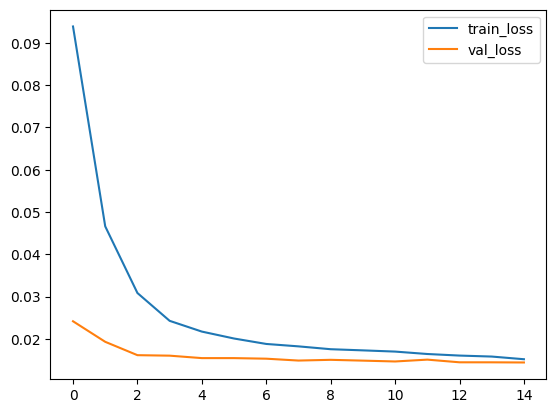

In [65]:
# Plot train_loss and val_loss
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [66]:
# Saving model parameters
torch.save(model.state_dict(), './Data/Model/model_weights.pth')

### Testing

In [67]:
#Loading the model
model = HousePricePredictor(num_tabular_features=df.shape[1]-2) 
model.load_state_dict(torch.load('./Data/Model/model_weights.pth'))
model.to(device).eval()

HousePricePredictor(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [68]:
dataset_test = HouseDataset(test_df, './Data/reduced_images/train', transform=None)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [69]:
def evaluate_model(model, data_loader):
    total_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():  # No need to track gradients
        for images, tabular_data, prices in data_loader:
            with autocast():
                outputs = model(images, tabular_data)
                loss = criterion(outputs, prices.view_as(outputs))
            total_loss += loss.item()
            predictions.extend(outputs.flatten().tolist())
            actuals.extend(prices.tolist())
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, predictions, actuals

In [70]:
avg_loss, predictions, actuals = evaluate_model(model, dataloader_test)

#### Métricas

In [71]:
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
r2 = r2_score(actuals, predictions)

In [72]:
print(f"Average Loss: {avg_loss}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

Average Loss: 0.01437742930856791
MAE: 0.07878607997932996
MSE: 0.014348086642496611
RMSE: 0.11978349904096394
R²: 0.22380668411013183


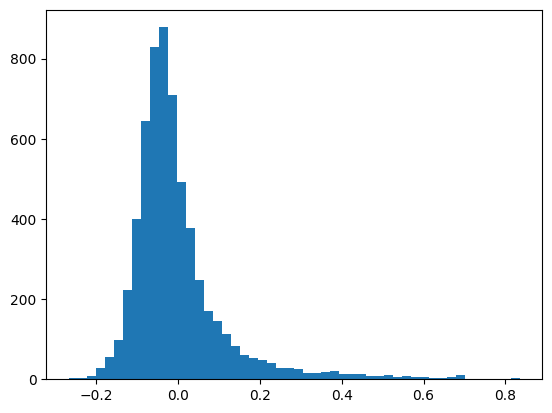

In [76]:
errors = []
for i in range(len(actuals)):
    errors.append(actuals[i] - predictions[i])
plt.hist(errors, bins=50)
plt.show()

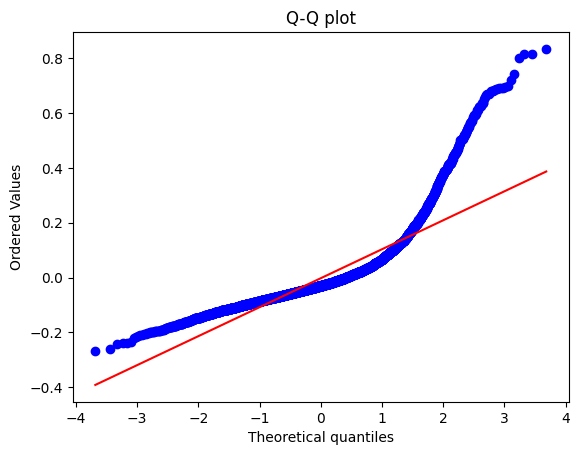

In [77]:
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

In [80]:
# Kolmogorov-Smirnov Test
ks_stat, ks_p = stats.kstest(errors, 'norm', args=(np.mean(errors), np.std(errors)))
print("Kolmogorov-Smirnov Test: statistic={}, p-value={}".format(ks_stat, ks_p))

# Anderson-Darling Test
ad_test = stats.anderson(errors, dist='norm')
print("Anderson-Darling Test: statistic={}, critical values={}, significance levels={}".format(ad_test.statistic, ad_test.critical_values, ad_test.significance_level))


Kolmogorov-Smirnov Test: statistic=0.16379630668283307, p-value=1.148512852651244e-140
Anderson-Darling Test: statistic=327.3841255617808, critical values=[0.576 0.656 0.786 0.917 1.091], significance levels=[15.  10.   5.   2.5  1. ]


![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)